## Example for computing parallel imaging g-factor using BART Python interface

Author: Jon Tamir <jtamir@eecs.berkeley.edu>

In [134]:
import numpy as np

import time

import cfl
from bart import bart

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

## Create multi-channel phantom in k-space

In [135]:
nx = 128
ny = 128
nc = 8

rx = 1
ry = 4

n_mc = 30


In [136]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-x d] [-3] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S Output nc sensitivities
-k		k-space
-t file      	trajectory
-x n      	dimensions in y and z
-3		3D
-h		help


## Estimate coil sensitivities

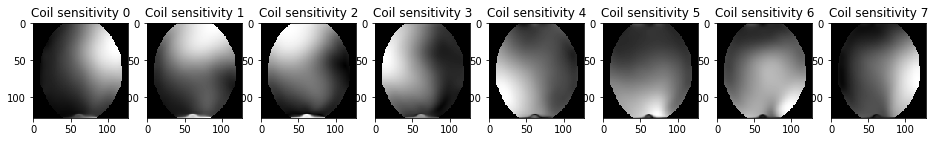

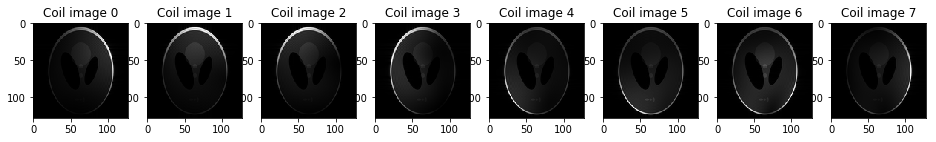

In [5]:
sens = bart(1, 'ecalib -m1', ksp[:,:,None,:]).squeeze()

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))
    
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## Create sampling patterns

Text(0.5,1,'CAIPI grid sampling pattern (N=4096.0)')

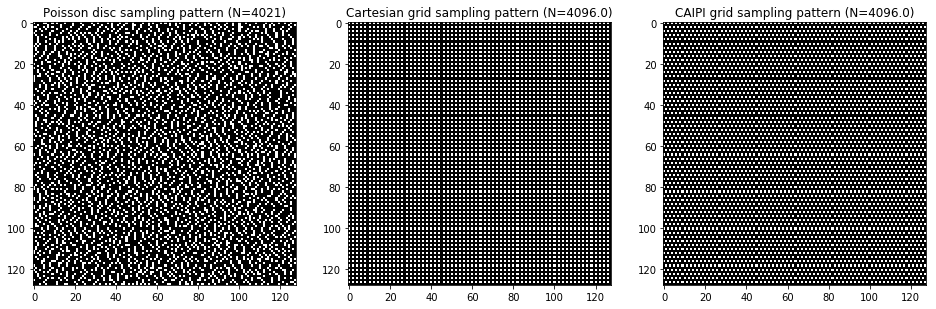

In [445]:
mask_pd = bart(1, 'poisson -Y {} -Z {} -y {} -z {}'.format(nx, ny, rx, ry)).squeeze() != 0
mask_cg = np.zeros((nx, ny))
mask_cg[::2,::2] = 1
mask_ca = np.copy(y)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(mask_pd, cmap='gray')
plt.title('Poisson disc sampling pattern (N={})'.format(np.sum(mask_pd)))
plt.subplot(1, 3, 2)
plt.imshow(mask_cg, cmap='gray')
plt.title('Cartesian grid sampling pattern (N={})'.format(np.sum(mask_cg)))
plt.subplot(1,3,3)
plt.imshow(y,cmap='gray')
plt.title('CAIPI grid sampling pattern (N={})'.format(np.sum(mask_ca)))

## apply masks and reconstruct

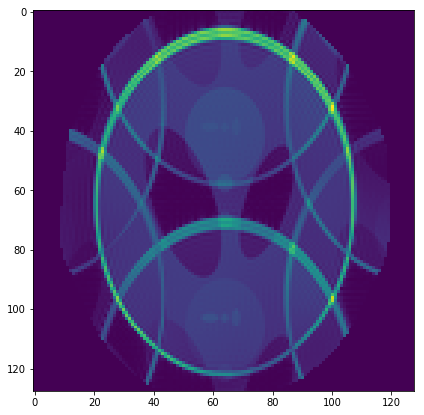

In [446]:
ksp_cg = ksp.copy() * mask_cg[:,:,None]
ksp_pd = ksp.copy() * mask_pd[:,:,None]
ksp_pd=ksp.copy()*y[:,:,None]
cimg = bart(1, 'fft -iu 3', ksp_pd)
plt.imshow(abs(np.sum(bart(1, 'fft -iu 3', ksp_pd)*np.conj(sens),axis=2)))

Text(0.5,1,'Caipi grid zero-filled')

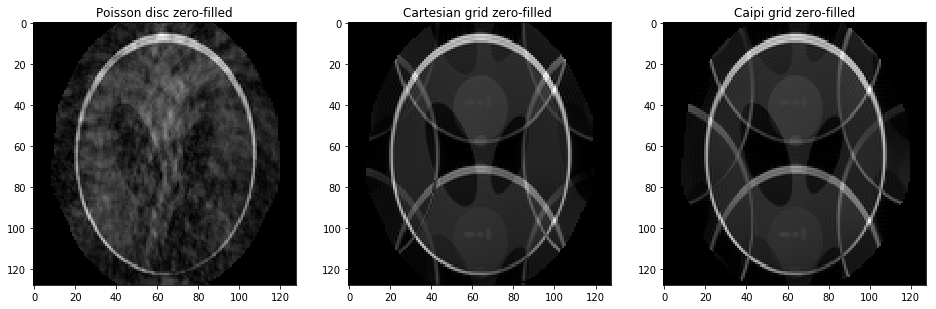

In [448]:
ksp_cg = ksp.copy() * mask_cg[:,:,None]
ksp_pd = ksp.copy() * mask_pd[:,:,None]
ksp_ca = ksp.copy()*y[:,:,None]
reco_pd_zfill = np.sum(bart(1, 'fft -iu 3', ksp_pd) * np.conj(sens), axis=2)
reco_cg_zfill = np.sum(bart(1, 'fft -iu 3', ksp_cg) * np.conj(sens), axis=2)
reco_ca_zfill = np.sum(bart(1, 'fft -iu 3', ksp_ca) * np.conj(sens), axis=2)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(abs(reco_pd_zfill).squeeze(), cmap='gray')
plt.title('Poisson disc zero-filled')

plt.subplot(1, 3, 2)
plt.imshow(abs(reco_cg_zfill).squeeze(), cmap='gray')
plt.title('Cartesian grid zero-filled ')

plt.subplot(1,3,3)
plt.imshow(abs(reco_ca_zfill).squeeze(),cmap='gray')
plt.title('Caipi grid zero-filled')


Text(0.5,1,'CAIPI grid noiseless reconstruction')

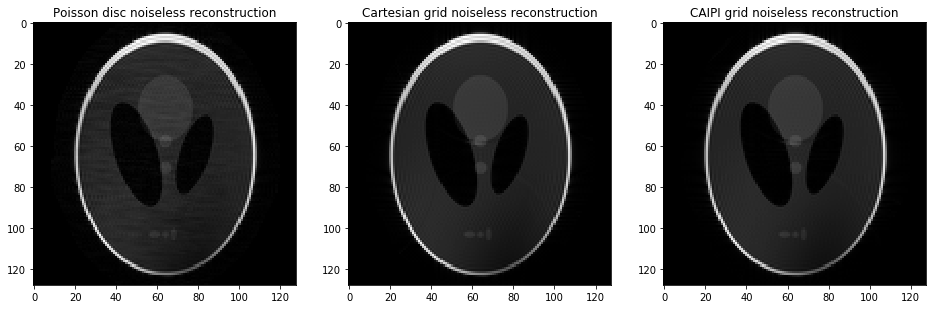

In [449]:
reco_cg_clean = bart(1, 'pics -S -i50', ksp_cg[:,:,None,:], sens[:,:,None,:])
reco_pd_clean = bart(1, 'pics -S -i50', ksp_pd[:,:,None,:], sens[:,:,None,:])
reco_ca_clean = bart(1, 'pics -S -i50', ksp_ca[:,:,None,:], sens[:,:,None,:])

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(abs(reco_pd_clean).squeeze(), cmap='gray')
plt.title('Poisson disc noiseless reconstruction')

plt.subplot(1, 3, 2)
plt.imshow(abs(reco_cg_clean).squeeze(), cmap='gray')
plt.title('Cartesian grid noiseless reconstruction')

plt.subplot(1, 3, 3)
plt.imshow(abs(reco_ca_clean).squeeze(), cmap='gray')
plt.title('CAIPI grid noiseless reconstruction')

## repeat reconstruction with N_MC noise instances

In [450]:
mask_cg=np.copy(y)

In [451]:
recons_cg = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_pd = np.zeros((nx, ny, n_mc), dtype=np.complex)
recons_ca = np.zeros((nx,ny,n_mc),dtype=np.complex)
tic = time.time()
for i in range(n_mc):

    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    ksp_noise_cg = mask_cg[:,:,None] * (ksp + ksp_noise)
    ksp_noise_pd = mask_pd[:,:,None] * (ksp + ksp_noise)
    ksp_noise_ca = mask_ca[:,:,None] * (ksp + ksp_noise)
        
    recons_cg[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_cg[:,:,None,:], sens[:,:,None,:])
    recons_pd[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_pd[:,:,None,:], sens[:,:,None,:])
    recons_ca[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise_ca[:,:,None,:], sens[:,:,None,:])
    
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (34.50729012489319 s)


## repeat reconstruction with N_MC noise-only instances

In [452]:
recons_noise = np.zeros((nx, ny, n_mc), dtype=np.complex)

tic = time.time()
for i in range(n_mc):
    
    ksp_noise = np.random.randn(*ksp.shape) + 1j*np.random.randn(*ksp.shape)
    recons_noise[:,:,i] = bart(1, 'pics -S -i 50', ksp_noise[:,:,None,:], sens[:,:,None,:])
    
toc = time.time()

print('Done ({} s)'.format(toc - tic))

Done (6.20416522026062 s)


## compute g-factor

Max PD g-factor value: 3.749978066348432
Max CG g-factor value: 3.3817950701686335
Max CA g-factor value: 3.38179701446161


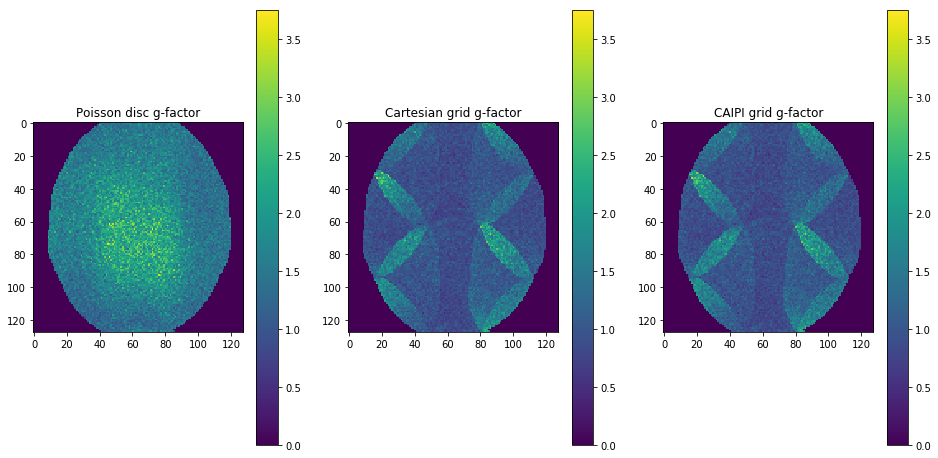

In [453]:
recon_noise_std = np.std(recons_noise, axis=2)
gfactor_cg = np.divide(np.std(recons_cg.real, axis=2), recon_noise_std, where=abs(recons_cg[:,:,0].squeeze()) != 0)
gfactor_pd = np.divide(np.std(recons_pd.real, axis=2), recon_noise_std, where=abs(recons_pd[:,:,0].squeeze()) != 0)
gfactor_ca = np.divide(np.std(recons_ca.real, axis=2), recon_noise_std, where=abs(recons_ca[:,:,0].squeeze()) != 0)


gfactor_cg /= np.sqrt(rx * ry)
gfactor_pd /= np.sqrt(rx * ry)
gfactor_ca /= np.sqrt(rx * ry)

max_gf_pd = np.max(gfactor_pd)
max_gf_cg = np.max(gfactor_cg)
max_gf_ca = np.max(gfactor_ca)

print('Max PD g-factor value: {}'.format(max_gf_pd))
print('Max CG g-factor value: {}'.format(max_gf_cg))
print('Max CA g-factor value: {}'.format(max_gf_ca))


plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(gfactor_pd, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('Poisson disc g-factor')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(gfactor_cg, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('Cartesian grid g-factor')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(gfactor_ca, vmax=np.max((max_gf_pd, max_gf_cg,max_gf_ca)))
plt.title('CAIPI grid g-factor')
plt.colorbar()